In [1]:
#!/usr/bin/python
import psycopg2
import sys
import pprint
import pandas as pd
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import openpyxl
import json
from datetime import datetime
from dateutil.relativedelta import relativedelta, FR

# Database Query Template
Provide shell for running queries against the database.

In [2]:
def getRecords(query):
    conn_string = "host='ec2-34-204-130-85.compute-1.amazonaws.com' dbname='dajagik9jf03kv' user='ufff9p79fblkso' password='pajqlppcmb52klbmpsmbtiucuqi'"
    # print the connection string we will use to connect
    # print("Connecting to database\n	->%s" % (conn_string))
 
    # get a connection, if a connect cannot be made an exception will be raised here
    conn = psycopg2.connect(conn_string)
 
    # conn.cursor will return a cursor object, you can use this cursor to perform queries
    cursor = conn.cursor()
    
    df = pd.read_sql_query(query ,con=conn)
    
    return df

# Determine End Dates for the Reports
Determines the date range for the reports. 
-0 represents the Friday of the current week
-1 represents the previous Friday
-2 2 Friday's ago etc.
Please check date printout to verify that the program uses the date range you intend. The default numbers
should work if the report is run on a Friday.

In [3]:
# Determines the date for the previous Friday
ref = datetime.now() + relativedelta(weekday=FR(-2))
lastFriday = str(ref.year) + '-' + str(ref.month) + '-' + str(ref.day) + 'T16:00:00'

# Determines the date for the current Friday
ref = datetime.now() + relativedelta(weekday=FR(-0))
curFriday = str(ref.year) + '-' + str(ref.month) + '-' + str(ref.day) + 'T14:00:00'

print(lastFriday)
print(curFriday)

2019-1-18T16:00:00
2019-2-1T14:00:00


In [4]:
query = """ SELECT "Claims"."state" AS "State",
       "Accounts"."name" AS "Group",
       "Users"."name" AS "Customer",
        TO_CHAR("Claims"."scheduled_window_start", 'YYYY-MM-DD"T"HH24":"MI') AS "Scheduled Window Start",
        "Claims"."id" AS "id"
        FROM "public"."claims" AS "Claims"
        INNER JOIN "public"."groups" AS "Groups" ON "Claims"."group_id" = "Groups"."id"
        INNER JOIN "public"."accounts" AS "Accounts" ON "Groups"."account_id" = "Accounts"."id"
        INNER JOIN "public"."devices" AS "Devices" ON "Claims"."device_id" = "Devices"."id"
        INNER JOIN "public"."users" AS "Users" ON "Devices"."user_id" = "Users"."id"
        WHERE ("Claims"."resolved_at"::DATE AT TIME ZONE 'UTC' >= """
query = query + "'" + lastFriday + "'"
query = query + """ AND "Claims"."resolved_at"::DATE AT TIME ZONE 'UTC' < """
query = query + "'" + curFriday + "')"
query = query + """ GROUP BY "Claims"."state",
                     TO_CHAR("Claims"."scheduled_window_start", 'YYYY-MM-DD"T"HH24":"MI'),
                     "Accounts"."name",
                     "Users"."name", "Claims"."id"
                    ORDER BY "State" ASC,
                     "Scheduled Window Start" DESC,
                     "Group" ASC, 
                     "Customer" ASC """

In [5]:
# Completed claims

queryc = """ select
        repair.id id,
        max(coalesce(condition.tier, 1)) tier
    from claims repair
    left join claims_claim_conditions ccc on ccc.claim_id = repair.id
    left join claim_conditions condition on ccc.claim_condition_id = condition.id
    where resolved_at between """
queryc = queryc + "'" + lastFriday + "'"
queryc = queryc + " and " + "'" + curFriday + "'" + " group by 1"

dfc = getRecords(queryc)
dfc = dfc.groupby('tier').count()
dfc['Percentage'] = 0.0
Total = dfc['id'].sum()
dfc['Percentage'] = round(100 * dfc['id'] / Total, 2)
dfc

,id,Percentage
tier,,
1,102,79.07
2,23,17.83
3,4,3.10


In [6]:
def nameState(state):
    if state == 0:
        return 'Requested'
    if state == 1:
        return 'Scheduled'
    if state == 2:
        return 'In Progress'
    if state == 3:
        return 'Completed'
    if state == 4:
        return 'Canceled'


In [7]:
df = getRecords(query)
df.State = df.State.apply(lambda x: nameState(x))

In [8]:
df.tail()

,State,Group,Customer,Scheduled Window Start,id
110,Completed,AT&T,Emma Squires,2019-01-17T22:00,59ca10d2-0e21-4695-a525-19edad22bfd3
111,Completed,Stanford University,Sandra Wong Martin,2019-01-17T18:00,cb22da56-5579-40ce-bcbc-17c9f3a023ea
112,Completed,Wireless Analytics,Jesus Loera,2019-01-17T17:00,9c80c54b-7923-46f6-82c7-bc76448ed9f2
113,Canceled,T. Rowe Price,Chuma Enwonwu,2019-01-28T21:30,152ecc28-f3d1-4e57-b994-d3a54b48ee14
114,Canceled,Rutgers,8649931818,2019-01-23T17:00,fb4f58d5-572d-498e-a2be-f0c7bcd47321


In [9]:
df_groups = df.groupby('Group').count()
df_groups.drop(['Customer', 'Scheduled Window Start', 'id'], axis=1, inplace=True)
Total = df_groups['State'].sum()
df_groups['% by Account'] = round(100 * df_groups['State'] / Total, 2)
df_groups.sort_values(['State'], ascending=[False], inplace = True)

In [10]:
status = []
states = df.groupby('State').count()
states = states['Group']
states.columns = ['Count']

# Calculate Percentages
try:
    Requested = round(100 * states['Requested'] / states.sum(), 2)
except:
    Requested = 0.00
    
try:
    Scheduled = round(100 * states['Scheduled'] / states.sum(), 2)
except:
    Scheduled = 0.00
try:
    InProgress = round(100 * states['In Progress'] / states.sum(), 2)
except:
    InProgress = 0.00
    
try:
    Completed = round(100 * states['Completed'] / states.sum(), 2)
except:
    Completed = 0.00
    
try:
    Canceled = round(100 * states['Canceled'] / states.sum(), 2)
except:
    Canceled = 0.00

status.append(['Requested', Requested])
status.append(['In Progress', InProgress])
status.append(['Completed', Completed])
status.append(['Scheduled', Scheduled])
status.append(['Canceled', Canceled])

states = pd.DataFrame(status)
states.columns = ['Status', 'Percentage']
states.sort_values(['Percentage'], ascending=[False], inplace = True)
states.reset_index(drop = True, inplace = True)

In [11]:
query = """ select distinct
        COALESCE(condition.tier, 1) as Tier, repair.id
    from claims repair
    left join claims_claim_conditions ccc on ccc.claim_id = repair.id
    left join claim_conditions condition on ccc.claim_condition_id = condition.id
    where repair.scheduled_window_start > """
query = query + "'" + lastFriday + "'"

tiers = getRecords(query)

In [12]:
output = pd.merge(df, tiers, on = 'id')
df_tiers = output[['State','tier','Customer','Group','Scheduled Window Start']].copy()
df_tiers.columns = ['State', 'Tier', 'Customer', 'Group', 'Scheduled Window Start']
df_tiers = df_tiers[df_tiers.State == 'Completed'].groupby(['Tier']).count()
df_tiers.columns = ['Count', 'Customer', 'Group', 'Scheduled Window Start']
Total = df_tiers['Count'].sum()
df_tiers['Percentage by Tier'] = round(100 * df_tiers['Count'] / Total, 2)
df_tiers.drop(['Customer', 'Group', 'Scheduled Window Start'], axis=1, inplace=True)
df.sort_values(['Group','Scheduled Window Start'], ascending=[True, True], inplace = True)

In [13]:
today = datetime.now()
df_groups.columns = ['Count', '% by Account']
dateFile = str(today.month) + '-' + str(today.day) + '-' + str(today.year)
filename = 'customer service ' + dateFile + '.xlsx'
writer = pd.ExcelWriter(filename)
df.to_excel(writer, 'Claims Data', index = False)
states.to_excel(writer, 'States Data', index = False)
df_tiers.to_excel(writer,'Percentage by Tier')
df_groups.to_excel(writer, '% by Group')
dfc.to_excel(writer, '% by Tier Completed')

lstate = df.State.map(lambda x: len(x)).max() + 1
lGroup = df.Group.map(lambda x: len(x)).max() + 1
lCustomer = df.Customer.map(lambda x: len(x)).max() + 1
lStart = len('Scheduled Window Start') + 2
lid = df.id.map(lambda x: len(x)).max() 

ws = writer.sheets['Claims Data']
ws.set_column(0, 1, lstate)
ws.set_column(1, 2, lGroup)
ws.set_column(2, 3, lCustomer)
ws.set_column(3, 4, lStart)
ws.set_column(4, 5, lid)

lstatus = states.Status.map(lambda x: len(x)).max() + 1
lPercentage = len('Percentage') + 1
ws = writer.sheets['States Data']
ws.set_column(0, 1, lstatus)
ws.set_column(1, 2, lPercentage)

ltiers = len('Percentage by Tier') + 1
ws = writer.sheets['Percentage by Tier']
ws.set_column(2, 3, ltiers)

lGroup = df_groups.index.map(lambda x: len(x)).max() + 1
lState = len('Count') + 1
lAccount = len('% by Account') + 1
ws = writer.sheets['% by Group']
ws.set_column(0, 1, lGroup)
ws.set_column(1, 2, lState)
ws.set_column(2, 3, lAccount)

writer.save()

In [14]:
# Tier moving average data

queryt = """ select
        repair.id id,
        max(coalesce(condition.tier, 1)) tier,
        to_date(EXTRACT(YEAR FROM "repair"."resolved_at")::text ||  EXTRACT(WEEK FROM "repair"."resolved_at"), 'yyyyww') as "WeekOf"
    from claims repair
    left join claims_claim_conditions ccc on ccc.claim_id = repair.id
    left join claim_conditions condition on ccc.claim_condition_id = condition.id
    where "repair"."resolved_at" > '04-01-2018' group by 1, 3 """

dft = getRecords(queryt)

dft.sort_values(['WeekOf'], ascending = [True], inplace = True)

dft = dft.groupby(['WeekOf','tier'])['tier'].count()
dft = pd.DataFrame(dft)
dft.columns = ['count']
dft = dft.unstack()
dft.fillna(0.0, inplace = True)
dft['Tier 1 Percentage'] = dft['count',1] / (dft['count', 1] + dft['count', 2] + dft['count',3])

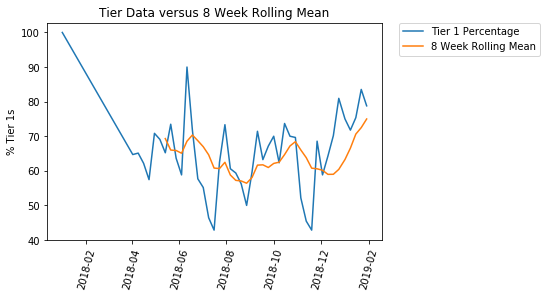

<Figure size 8640x6480 with 0 Axes>

In [15]:
dft_rolling4 = dft.rolling(window = 8).mean()
dfa = pd.merge(dft, dft_rolling4, on = 'WeekOf')
dfa = dfa[['Tier 1 Percentage_x', 'Tier 1 Percentage_y']]
dfa.columns = ['Tier 1 Percentage', '8 Week Rolling Mean']

# Change to percent
dfa = 100 * dfa
plt = dfa.plot(title='Tier Data versus 8 Week Rolling Mean', rot = 75)
plt.set_xlabel('')
plt.set_ylabel('% Tier 1s')
fig = figure(num=None, figsize=(8, 6), dpi=1080, facecolor='w', edgecolor='k')
_fig = plt.get_figure()
_fig.savefig('tierplots.png', bbox_inches='tight', dpi = 300)

# # Your plot generation code here...
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

wb = openpyxl.load_workbook(filename)
ws = wb.create_sheet('Tier Rolling Mean')
img = openpyxl.drawing.image.Image('tierplots.png')
img.height = 0.40 * img.height
img.width = 0.40 * img.width
ws.add_image(img, 'B3')

# ws.add_image(img)
wb.save(filename)

In [16]:
dft.head()

count            Tier 1 Percentage
tier           1     2    3                  
WeekOf                                       
2018-01-01   2.0   0.0  0.0          1.000000
2018-04-02  22.0  11.0  1.0          0.647059
2018-04-09  28.0  13.0  2.0          0.651163
2018-04-16  23.0  13.0  1.0          0.621622
2018-04-23  27.0  19.0  1.0          0.574468